# Splitting data to avoid overfitting!


A way to avoid overfitting is by splitting your data randomly into two subsets:

* Train data: The data that we fit our model on and decide the way in which predictions are made

* Test data: The data that we will use to check how well we are doing

Since we did not fit our model with the test data, the goodness of fit results (our score or $R^2$ lets us know how well the model we fitted works on data it has never seen.

This split is why we usually say "we are training the model" meaning we fit on training data. 


We will do one more exploration with the 2016 election data. 

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor as knn

In [2]:
#Let's load the election dataframe

url = 'https://raw.githubusercontent.com/mwaugh0328/Data_Bootcamp_Fall_2017/master/data_bootcamp_1127/trump_data.csv'
df = pd.read_csv(url,encoding='latin-1',index_col=0)
df = df.dropna(subset=['income'])
df['lnpop'] = np.log(df['population'])
df.head()


,population,income,NAME,county,state,FIPS,StateCode,StateName,CountyFips,CountyName,CountyTotalVote,Party,Candidate,VoteCount,_merge,trump_share,lnpop
0,55221.0,51281.0,"Autauga County, Alabama",1,1,1001.0,AL,alabama,1001,Autauga,24661,GOP,Trump,18110.0,both,0.734358,10.919099
5,195121.0,50254.0,"Baldwin County, Alabama",3,1,1003.0,AL,alabama,1003,Baldwin,94090,GOP,Trump,72780.0,both,0.773515,12.181375
10,26932.0,32964.0,"Barbour County, Alabama",5,1,1005.0,AL,alabama,1005,Barbour,10390,GOP,Trump,5431.0,both,0.522714,10.201070
15,22604.0,38678.0,"Bibb County, Alabama",7,1,1007.0,AL,alabama,1007,Bibb,8748,GOP,Trump,6733.0,both,0.769662,10.025882
20,57710.0,45813.0,"Blount County, Alabama",9,1,1009.0,AL,alabama,1009,Blount,25384,GOP,Trump,22808.0,both,0.898519,10.963186


In [3]:
#Let's do a really overfitting model, let's use just 2 
#neighbors!
sklearn_knn = knn(n_neighbors=2).fit(X=df[['lnpop']],y=df['trump_share'])

#Let's get our fit score

sklearn_knn.score(X=df[['lnpop']],y=df['trump_share'])


0.655272471671432

In [4]:
df['pred_knn'] = sklearn_knn.predict(df[['lnpop']])


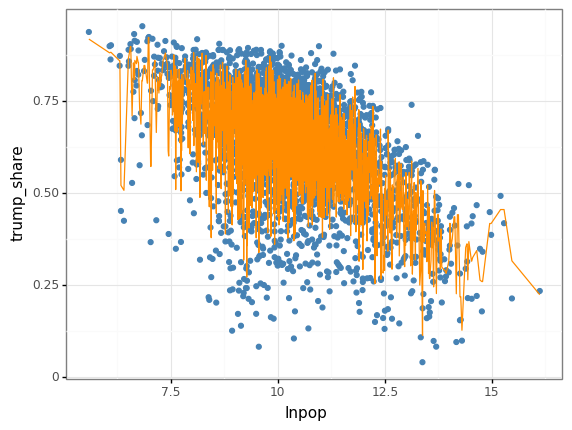

<ggplot: (8761615905395)>

In [5]:
#plot
(ggplot(df, aes(x='lnpop', y='trump_share'))+
       geom_point(color='steelblue')+
 geom_line(aes(x='lnpop', y='pred_knn'), color='darkorange' )+
 theme_bw()
       )


In [6]:
#This is the module we will need

from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df,
                               test_size=0.2, 
                               random_state=42,
                               shuffle=True)


In [8]:
print("The size of the election dataset", df.shape[0])
print("The size of the train dataset", train.shape[0])
print("The size of the test dataset",test.shape[0] )

The size of the election dataset 3111
The size of the train dataset 2488
The size of the test dataset 623


In [9]:
#Let's use a 5neighbor model to see how it works

#For the train data
knn(n_neighbors=5).fit(train[['lnpop']],
                       train['trump_share']).score(train[['lnpop']],
                                                   train['trump_share'])

0.4256422960193075

In [10]:
#And fitting on the train data and scoring on the test data

knn(n_neighbors=5).fit(train[['lnpop']],
                       train['trump_share']).score(test[['lnpop']],
                                                   test['trump_share'])



0.11689561118656677

In [11]:
#Let's look at the scores for different numbers of neighbors

scoretrain=[knn(n_neighbors=i).fit(train[['lnpop']],
            train['trump_share']).score(train[['lnpop']],
            train['trump_share']) for i in list(range(5, 500, 2))]


In [12]:
trainscore=pd.DataFrame(scoretrain, columns=["score"])

trainscore['datsplit']='Training'
trainscore['neighbors']=list(range(5, 500, 2))

In [13]:
trainscore.head()

,score,datsplit,neighbors
0,0.425642,Training,5
1,0.390050,Training,7
2,0.364498,Training,9
3,0.352634,Training,11
4,0.345748,Training,13


In [14]:
#Now, let's look at the scores on the testing split

scoretest=[knn(n_neighbors=i).fit(train[['lnpop']],
            train['trump_share']).score(test[['lnpop']],
            test['trump_share']) for i in list(range(5, 500, 2))]




In [15]:
testscore=pd.DataFrame(scoretest, columns=["score"])

testscore['datsplit']='Testing'

testscore['neighbors']=list(range(5, 500, 2))

In [16]:
testscore.head()

,score,datsplit,neighbors
0,0.116896,Testing,5
1,0.138561,Testing,7
2,0.164469,Testing,9
3,0.183409,Testing,11
4,0.199241,Testing,13


In [17]:
score_df=pd.concat([trainscore,testscore], axis=0)

score_df.tail()

,score,datsplit,neighbors
243,0.227607,Testing,491
244,0.227778,Testing,493
245,0.227622,Testing,495
246,0.227086,Testing,497
247,0.227192,Testing,499


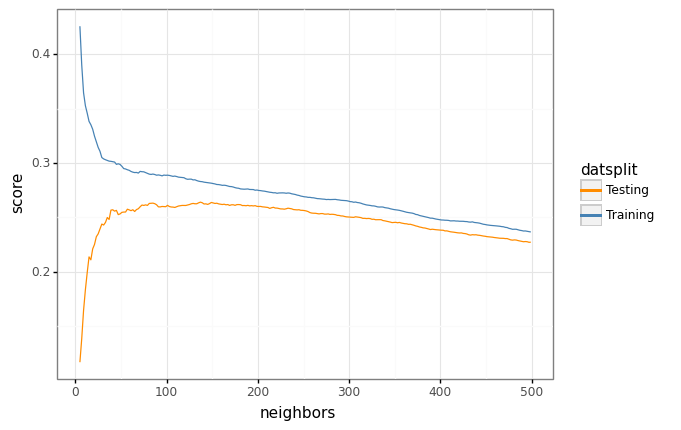

<ggplot: (8761616008735)>

In [18]:
(ggplot(score_df, aes(x='neighbors', y='score', color='datsplit'))+
geom_line()+
scale_color_manual(values=['darkorange', 'steelblue'])+
 theme_bw()
)

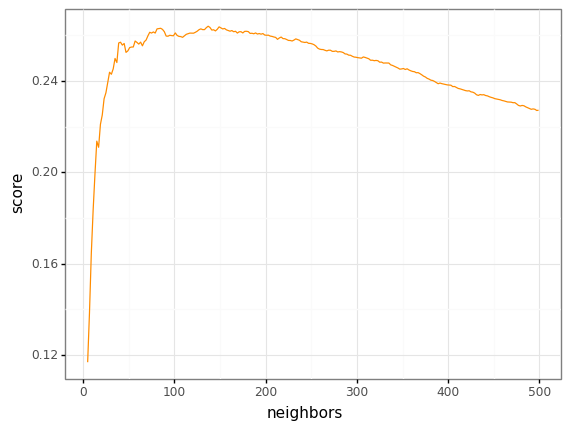

<ggplot: (8761599083755)>

In [19]:
(ggplot(testscore, aes(x='neighbors', y='score'))+
geom_line(color='darkorange')+
 theme_bw()
)

In [20]:
testscore['score'].max()

0.2639778726150459

In [21]:
#What is the optimal number of neighbors
testscore.loc[testscore['score']==testscore['score'].max(), 
              'neighbors']

66    137
Name: neighbors, dtype: int64

Could we do this in a more automatic way that is not totally dependent on getting lucky that the split is representative?


#### Train_test_split

What we have done

Shuffle


2 groups: A (train), B (test)



To find the hyperparameters that give us the best result, we get the scores of this split by testing several and finding the one that does best


#### Cross_validation

Shuffle

4 groups: A, B, C, D

1) train on A,B,C ; test on D


2) train on A,B,D ; test on C


3) train on A,C,D ; test on B


4) train on B,C,D ; test on A


To find the hyperparameters that are optimal we find the scores for a large range of hyperparameters, find the average of all the test scores and we use set the means for each. Then our best hyperparameter value will be the one matched to that mean.

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
#Let's do crossvalidation scores for a single value 
# (10 neighbors) and 5 groups

cross_val_score(knn(n_neighbors=10),X=df[['lnpop']],
                y=df['trump_share'],cv=5)


array([0.17388543, 0.26619629, 0.25009166, 0.11724544, 0.15059702])

In [24]:
#Let's obtain the mean

cross_val_score(knn(n_neighbors=10),X=df[['lnpop']],
                y=df['trump_share'],cv=5).mean()


0.19160316668072827

In [25]:
scoreCV=[cross_val_score(knn(n_neighbors=i),X=df[['lnpop']],
                y=df['trump_share'],
                         cv=5).mean() for i in list(range(5, 500))]



In [26]:
df_CV=pd.DataFrame(scoreCV, columns=['scores'])
df_CV['neighbors']=list(range(5, 500))

df_CV.head()

,scores,neighbors
0,0.099552,5
1,0.132591,6
2,0.149851,7
3,0.167414,8
4,0.177055,9


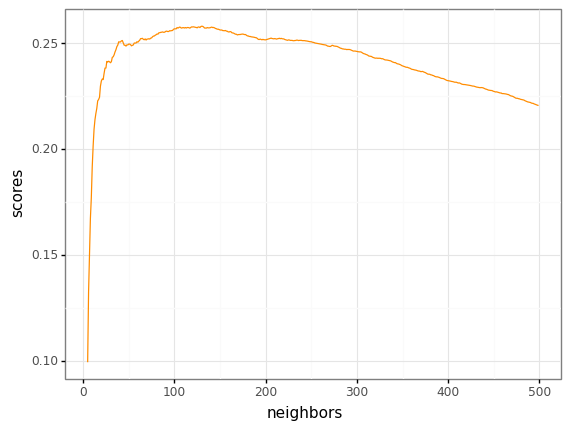

<ggplot: (8761654298890)>

In [27]:
(ggplot(df_CV, aes(x='neighbors', y='scores'))+
 geom_line(color='darkorange')+
theme_bw())

In [28]:
#What is the max score?

df_CV.scores.max()

0.25812648961312246

In [29]:
#Let's get the optimal neighbors

df_CV.loc[df_CV['scores']==df_CV.scores.max(), 'neighbors']

125    130
Name: neighbors, dtype: int64

We have 130 neighbors!!!


In [30]:
#Let's drop the prediction column

df.drop(columns=['pred_knn'], inplace=True)

In [31]:
#Let's replace it with the 130 neighbors

df['pred_knn']=knn(n_neighbors=130).fit(X=df[['lnpop']],
                       y=df['trump_share']).predict(df[['lnpop']])


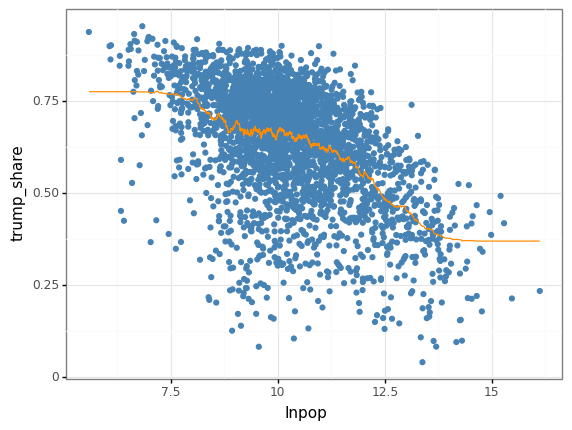

<ggplot: (8761616305210)>

In [32]:
(ggplot(df, aes(x='lnpop', y='trump_share'))+
       geom_point(color='steelblue')+
 geom_line(aes(x='lnpop', y='pred_knn'), color='darkorange' )+
 theme_bw()
       )

In [33]:
 from sklearn.ensemble import RandomForestRegressor as rf

In [34]:
# We will set the number of estimators fixed at 100
# and iterate in the tree depth up to seven


scoresrf=[cross_val_score(rf(n_estimators=100,max_depth=i),
                          df[['lnpop']],df['trump_share'],
                          cv=5).mean() for i in list(range(1,7))
    ]

In [35]:
rf_df=pd.DataFrame(scoresrf, columns=['scores'])

rf_df['depth']=list(range(1,7))

In [36]:
rf_df

,scores,depth
0,0.192046,1
1,0.250473,2
2,0.260916,3
3,0.256011,4
4,0.253609,5
5,0.245501,6


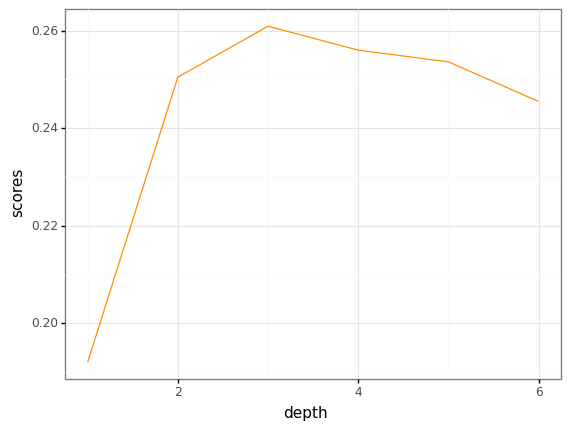

<ggplot: (8761633633497)>

In [37]:
(ggplot(rf_df, aes(x='depth', y='scores'))+
geom_line(color='darkorange')+
theme_bw())

In [38]:
#Let's find the maximum depth

rf_df.loc[rf_df['scores']==rf_df.scores.max(), 'depth']

2    3
Name: depth, dtype: int64

In [39]:
# We see that the max depth of 3 works well!

df['pred_rf']=rf(n_estimators=100,max_depth=3).fit(X=df[['lnpop']],
                       y=df['trump_share']).predict(df[['lnpop']])


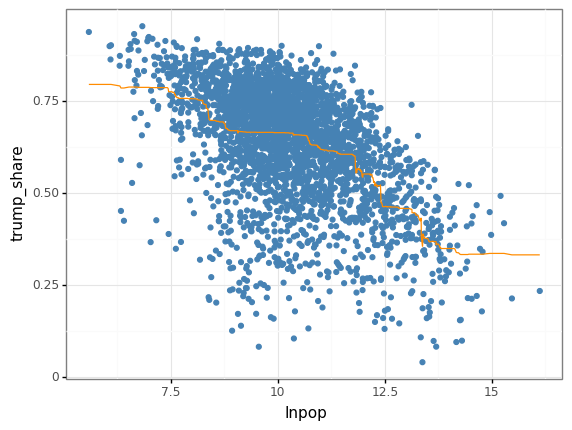

<ggplot: (8761654321351)>

In [40]:
(ggplot(df, aes(x='lnpop', y='trump_share'))+
       geom_point(color='steelblue')+
 geom_line(aes(x='lnpop', y='pred_rf'), color='darkorange' )+
 theme_bw()
       )

In [41]:
#prepare dataframe

plotdf=df[['lnpop', 'trump_share', 'pred_knn', 'pred_rf']]

In [42]:
plotdf1=pd.melt(plotdf, id_vars=['lnpop', 'trump_share'],
                value_vars=["pred_knn", "pred_rf"],
                var_name='model', value_name="predictions")

In [43]:
plotdf1.head()

,lnpop,trump_share,model,predictions
0,10.919099,0.734358,pred_knn,0.629086
1,12.181375,0.773515,pred_knn,0.535898
2,10.201070,0.522714,pred_knn,0.663571
3,10.025882,0.769662,pred_knn,0.673381
4,10.963186,0.898519,pred_knn,0.635431


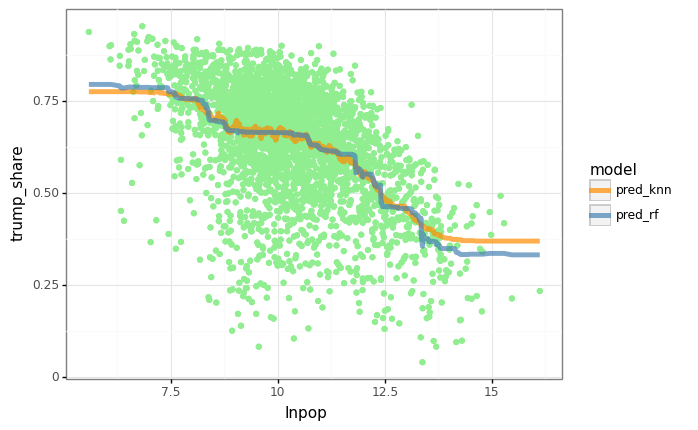

<ggplot: (8761616030043)>

In [44]:
#Let's see how the optimal rnn and optimal rf match!


(ggplot(plotdf1, aes(x='lnpop', y='trump_share', color='model'))+
 geom_point(color='lightgreen')+
geom_line(aes(x='lnpop', y='predictions'), alpha=0.7, size=2)+
 scale_color_manual(values=['darkorange', 'steelblue'])+
theme_bw())

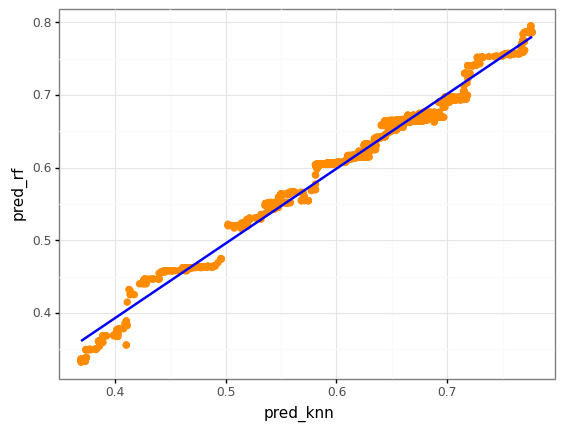

<ggplot: (8761624453169)>

In [45]:
(ggplot(df, aes(x='pred_knn', y='pred_rf'))+
       geom_point(color='darkorange', size=2)+
 geom_smooth(color='blue')+
theme_bw())

In [46]:
dfsq=df[['trump_share', 'pred_knn', 'pred_rf']].corr()**2
dfsq

,trump_share,pred_knn,pred_rf
trump_share,1.000000,0.283886,0.290369
pred_knn,0.283886,1.000000,0.983454
pred_rf,0.290369,0.983454,1.000000


In [47]:
#Let's make a heatmap

listoflist = []
for in1 in dfsq.index:
    for in2 in dfsq.columns:
        listoflist.append([in1, in2, dfsq.loc[in1, in2]])

heatdf = pd.DataFrame(data=listoflist, columns=["att1", "att2", "R2"])

heatdf

,att1,att2,R2
0,trump_share,trump_share,1.000000
1,trump_share,pred_knn,0.283886
2,trump_share,pred_rf,0.290369
3,pred_knn,trump_share,0.283886
4,pred_knn,pred_knn,1.000000
5,pred_knn,pred_rf,0.983454
6,pred_rf,trump_share,0.290369
7,pred_rf,pred_knn,0.983454
8,pred_rf,pred_rf,1.000000


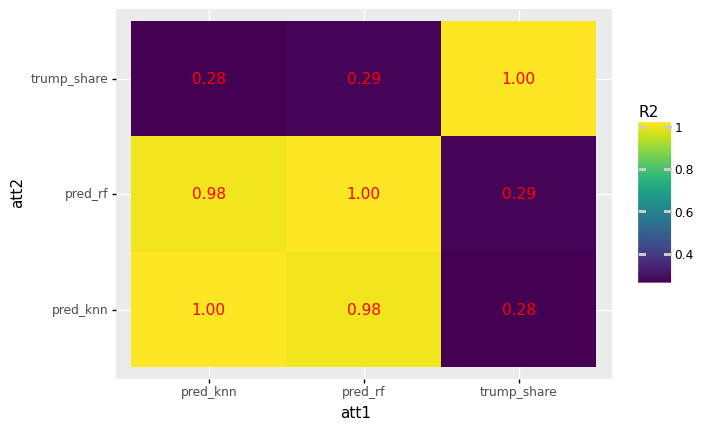

<ggplot: (8761654626946)>

In [48]:
(ggplot(data=heatdf, mapping= aes(x='att1', y='att2', fill='R2'))+
 geom_tile()+
 geom_text(aes(x='att1', y='att2', label='R2'),
           format_string='{:.2f}',
          color='red')
 )